In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import json
from collections import Counter
from networkx import eigenvector_centrality
from networkx import communicability_betweenness_centrality
from networkx.algorithms.community import k_clique_communities
from community import community_louvain
from matplotlib.cm import ScalarMappable

In [ ]:
NODE_SIZE = 100

In [ ]:
edges = pd.read_csv('/database/lastfm_asia_edges.csv')
# Read edges from CSV file
G = nx.from_pandas_edgelist(edges, 'node_1', 'node_2')

In [ ]:
target = pd.read_csv('database/lastfm_asia_target.csv')
# Read binary targets from CSV file and add them as node attributes
targets_dict = dict(zip(target['id'], target['target']))
nx.set_node_attributes(G, targets_dict, 'target')

In [ ]:
POS = nx.spring_layout(G)

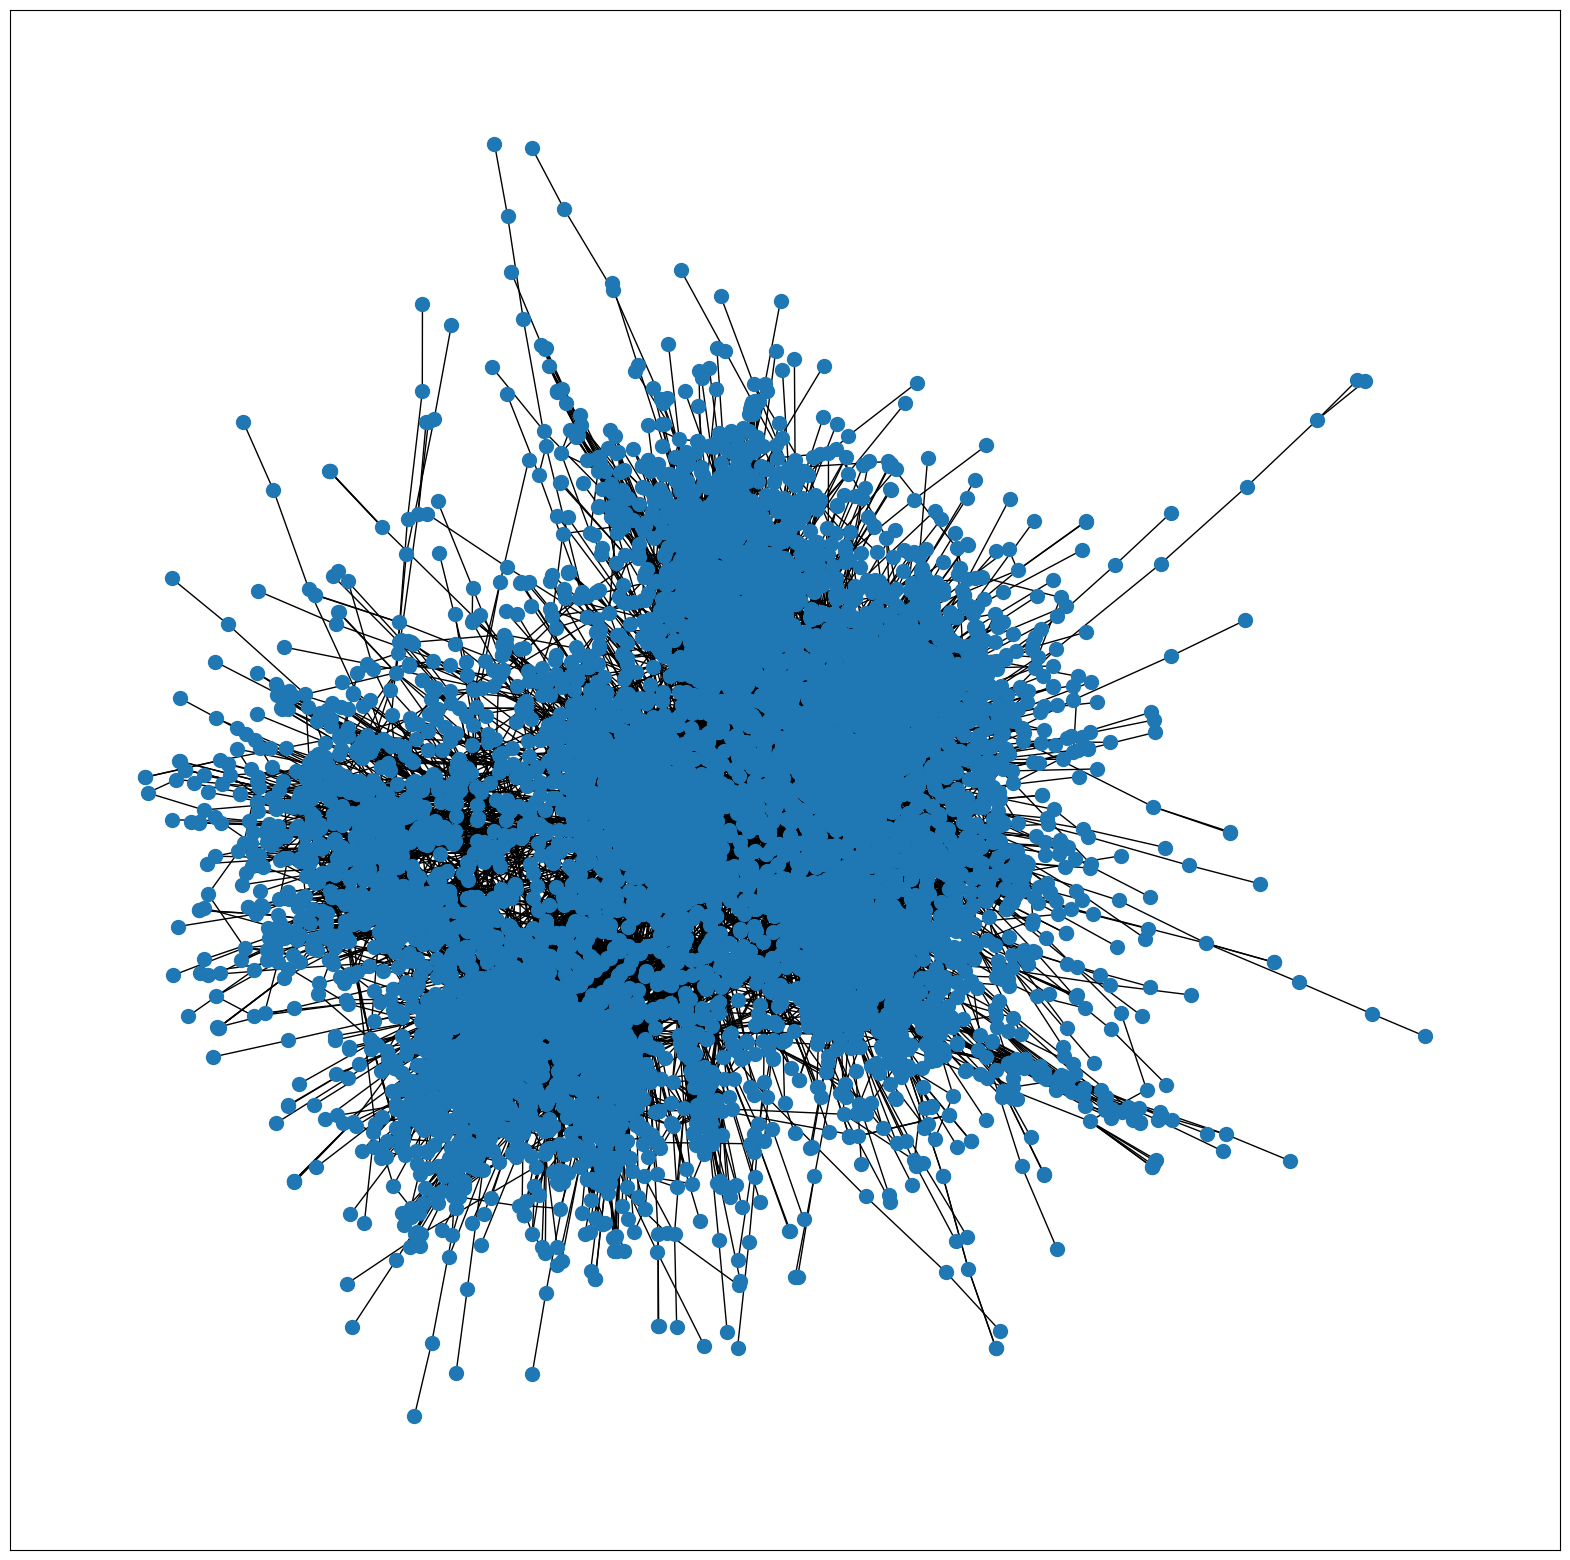

In [ ]:
#Build the network's graph
plt.figure(figsize=(10,10))
nx.draw_networkx(G, pos=POS, with_labels=False, node_size=NODE_SIZE)

###Degree Centrality



In [123]:
#Add colorbar to the network graph
def add_colorbar(metric, label):
  norm = plt.Normalize(min(metric.values()), max(metric.values()))
  sm = ScalarMappable(norm=norm)
  sm.set_array([])
  cbar = plt.colorbar(sm, orientation="vertical", pad=0.02, shrink=0.6)
  cbar.set_label(label, fontsize=12)
  cbar.ax.tick_params(labelsize=12)
  return cbar

In [117]:
degree_centr = nx.degree_centrality(G)

<ipython-input-123-1411c2984644>:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation="vertical", pad=0.02, shrink=0.6)


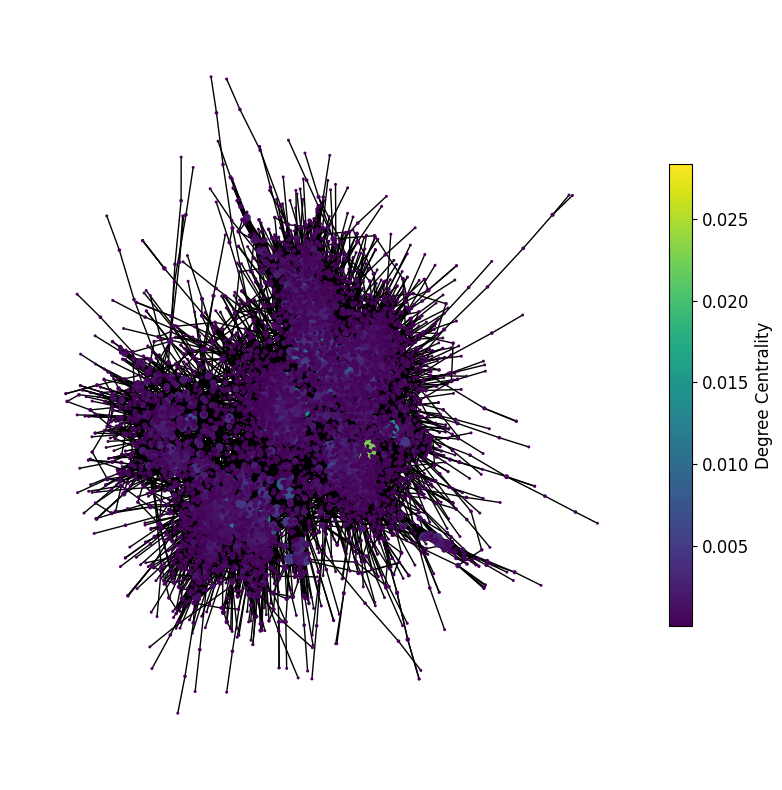

In [126]:
node_color = [G.degree(v) for v in G]
node_size = [v * 10000 for v in degree_centr.values()]
plt.figure(figsize=(10,10))
nodes = nx.draw_networkx(G, pos=POS, with_labels=False, node_color=node_color, node_size=node_size)
plt.axis('off')
cbar = add_colorbar(degree_centr, 'Degree Centrality')

###Eigenvector Centrality

In [ ]:
eigvec_centr = eigenvector_centrality(G, max_iter=100, tol=1e-06, nstart=None, weight=None)

<ipython-input-123-1411c2984644>:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation="vertical", pad=0.02, shrink=0.6)


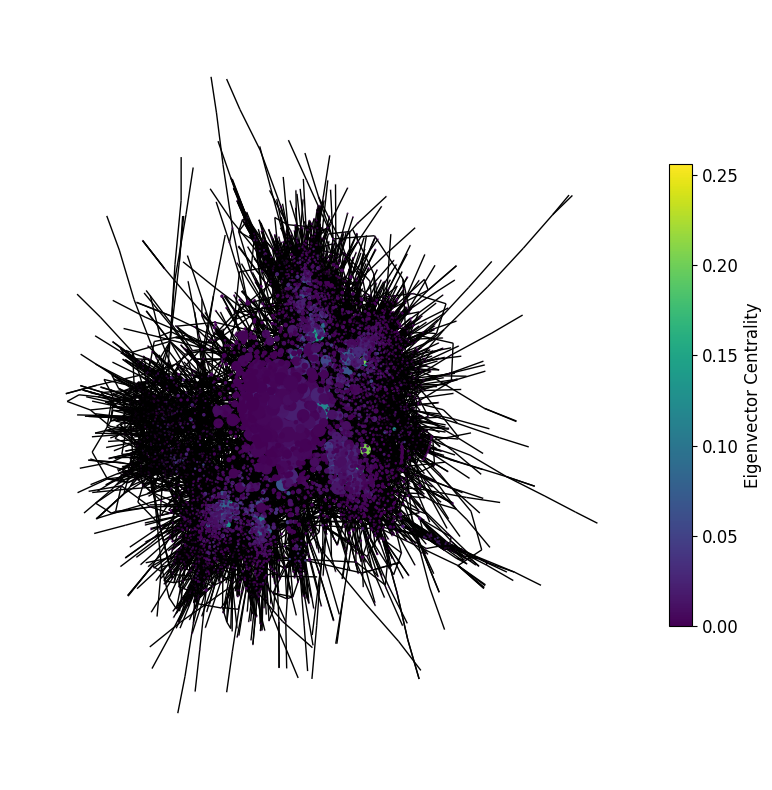

In [127]:
node_color = [G.degree(v) for v in G]
node_size = [v * 10000 for v in eigvec_centr.values()]
plt.figure(figsize=(10,10))
nx.draw_networkx(G, pos=POS, with_labels=False, node_color=node_color, node_size=node_size)
plt.axis('off')
cbar = add_colorbar(eigvec_centr, 'Eigenvector Centrality')

###k-Core

In [ ]:
cliques = nx.find_cliques(G)
cliques10 = [clq for clq in cliques if len(clq) >= 10]
nodes = set(n for clq in cliques10 for n in clq)
sub_g = G.subgraph(nodes)
deg = nx.degree(sub_g)
nodes = [n for n in nodes if deg[n] >= 10]
c10 = sub_g.subgraph(nodes)

(-0.3142373903095722,
 0.28575855925679206,
 -0.3959462597221136,
 0.289201180562377)

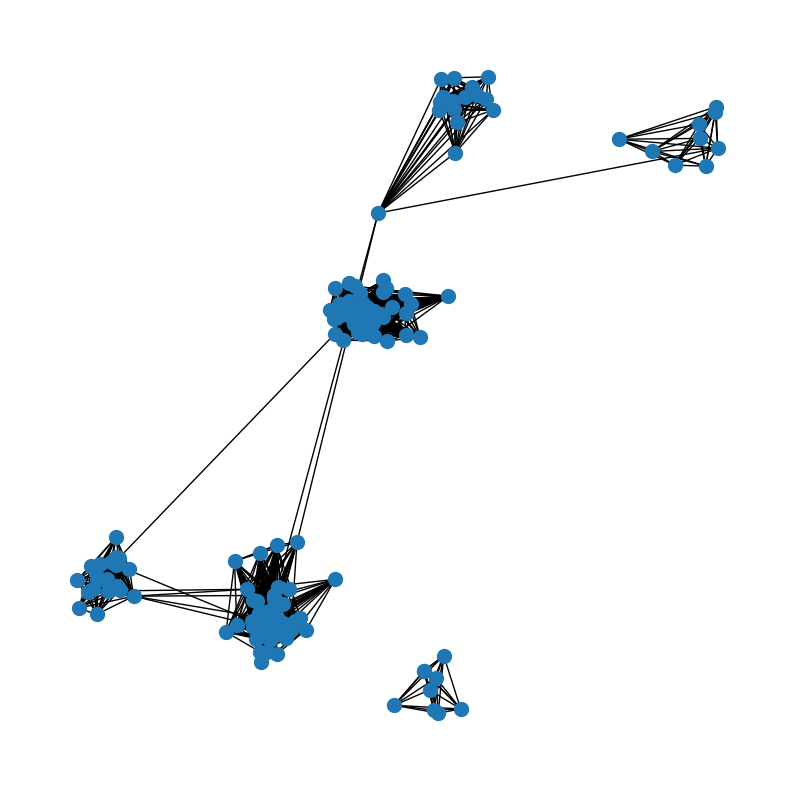

In [ ]:
plt.figure(figsize=(10,10))
nx.draw_networkx(c10, pos=POS, with_labels=False, node_size=NODE_SIZE)
plt.axis('off')

###Clustering and Transitivity

In [ ]:
avg_clustering = nx.average_clustering(G)
print("Clustering Coefficient:", avg_clustering)

Clustering Coefficient: 0.2194184243270858


In [ ]:
transitivity = nx.transitivity(G)
print("Transitivity:", transitivity)

Transitivity: 0.178622548153384


###Communities

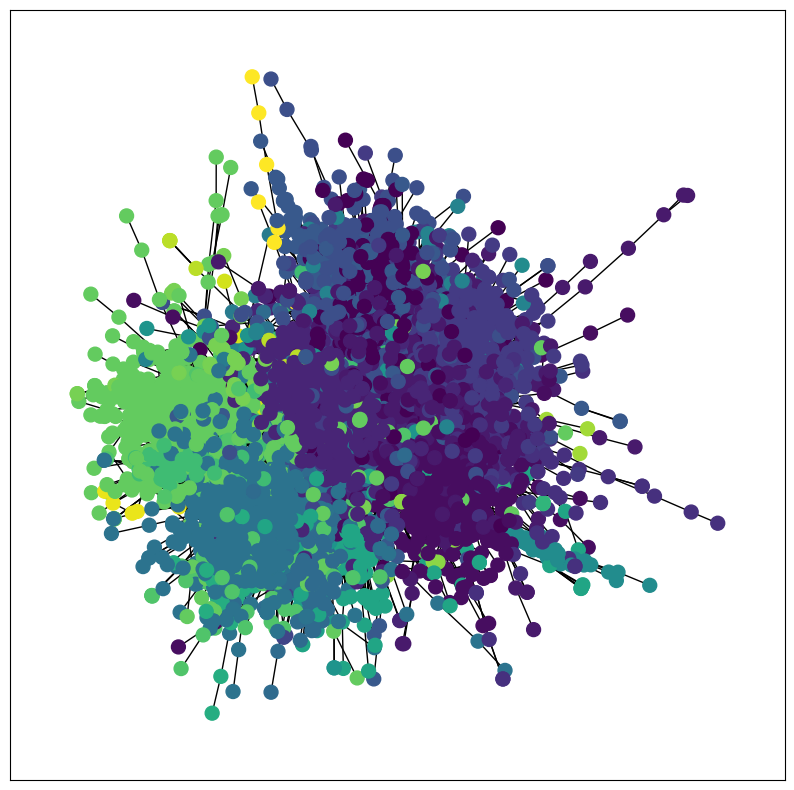

In [ ]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):
    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):
    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

partition = community_louvain.best_partition(G)
pos = community_layout(G, partition)

plt.figure(figsize=(10,10))
nx.draw_networkx(G, pos=POS, with_labels=False, node_color=list(partition.values()), node_size=NODE_SIZE)

###Degree Centrality Distribution

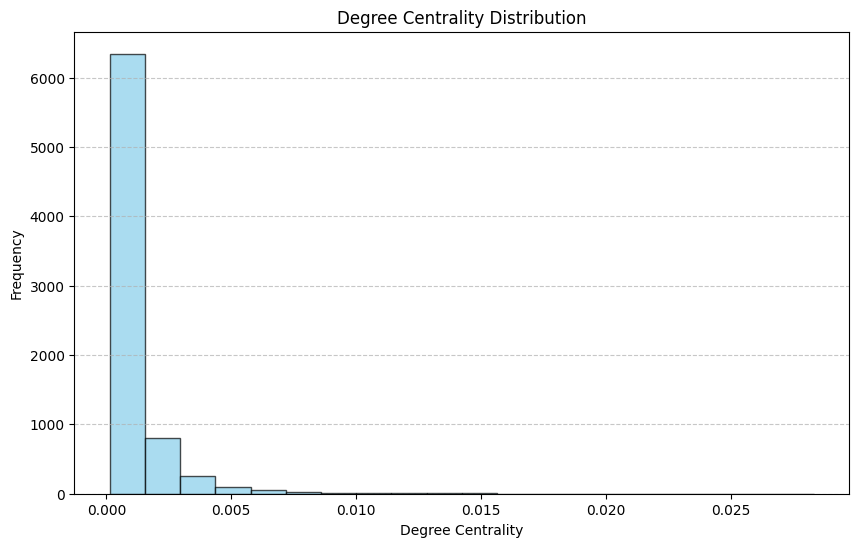

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(degree_centr.values(), bins=20, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Degree Centrality Distribution')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

###Eigenvector Centrality Distribution

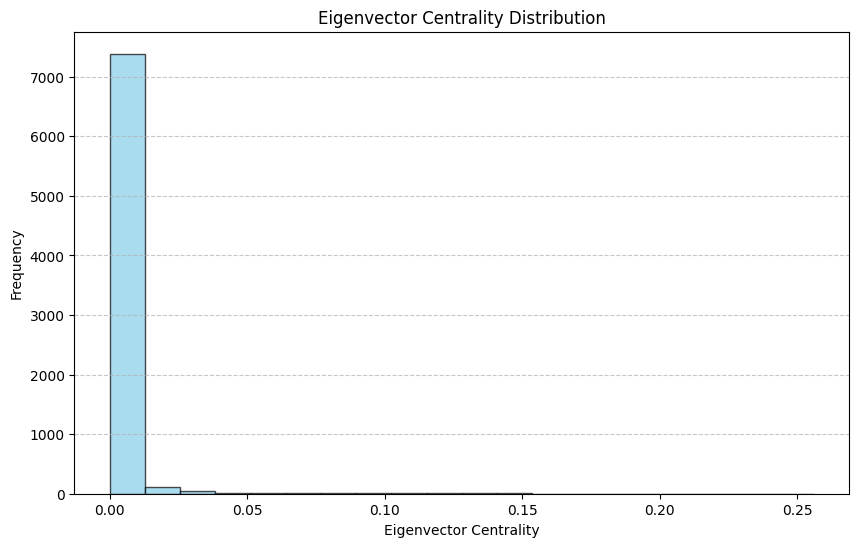

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(eigvec_centr.values(), bins=20, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Eigenvector Centrality Distribution')
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
import seaborn as sns

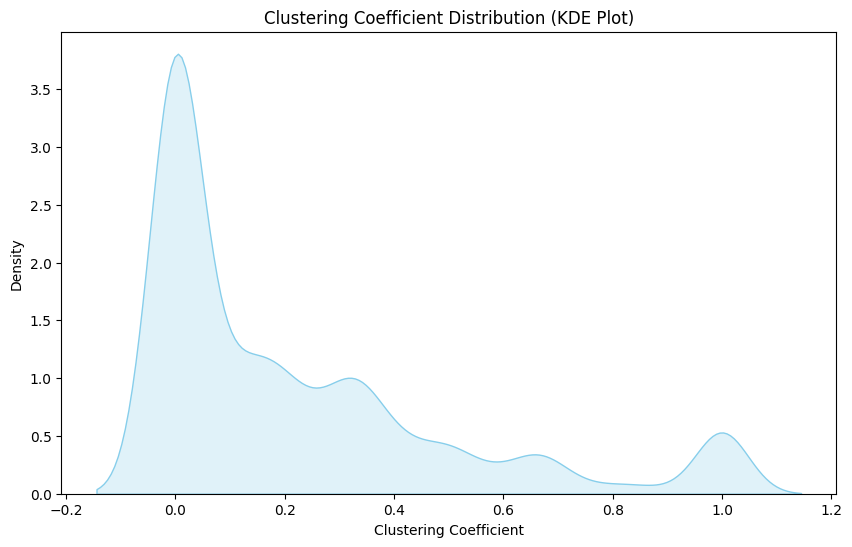

In [ ]:
# Calculate clustering coefficients
clustering_coefficients = nx.clustering(G)

# Plot the clustering coefficient distribution with a KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(list(clustering_coefficients.values()), color='skyblue', fill=True)

plt.title('Clustering Coefficient Distribution')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Density')

plt.show()